In [ ]:
from google.colab import drive
from google.colab import files
import os
drive.mount('/content/drive')
os.chdir('/content')
!nvidia-smi

import torch, torchvision
print(torch.__version__, torch.cuda.is_available())

!git clone https://github.com/facebookresearch/detectron2.git
!python -m pip install -e detectron2

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Mon Dec 13 07:18:24 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   70C    P8    12W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+------

In [ ]:
!mkdir /content/data
%cd data

from google_drive_downloader import GoogleDriveDownloader as gdd
import os
import re
import shutil

#load dataset
gdd.download_file_from_google_drive(file_id='1nEJ7NTtHcCHNQqUXaoPk55VH3Uwh4QGG',
                                    dest_path='./dataset.zip',
                                    unzip=True)

#this is for annotaion.json from prepare_anno
gdd.download_file_from_google_drive(file_id='1WTxF13cjdoBCgt2hKBpnJ7vbbjtGuQOR',
                                    dest_path='./dataset/annotations.zip',
                                    unzip=True)

def modify_dataset_to_coco():
    
    
    train_names = os.listdir('./dataset/train')
    train_names = list(filter(lambda x: re.match('TCGA', x) != None, train_names))
    
    for tr_name in train_names:
        tr_img_path = os.path.join('dataset', 'train', tr_name, 'images', tr_name+'.png')
        new_tr_img_path = os.path.join('dataset', 'train', tr_name+'.png')
        os.rename(tr_img_path, new_tr_img_path)
    
    for folder_name in train_names:
        shutil.rmtree(f'./dataset/train/{folder_name}', ignore_errors=True)

modify_dataset_to_coco()

%cd /content

mkdir: cannot create directory ‘/content/data’: File exists
/content/data


NotADirectoryError: ignored

In [ ]:
%cd /content
from detectron2.data.datasets import register_coco_instances

#train:
register_coco_instances('train_custom', {}, '/content/data/dataset/annotations.json', '/content/data/dataset/train')
#test:
register_coco_instances('test_custom', {}, '/content/data/dataset/test_img_ids.json', '/content/data/dataset/test')


In [ ]:
import argparse
import sys
from detectron2.config import get_cfg
from detectron2.data import DatasetMapper, MetadataCatalog, build_detection_train_loader
from detectron2.engine import DefaultTrainer, default_argument_parser, default_setup, launch
from detectron2.evaluation import CityscapesSemSegEvaluator, DatasetEvaluators, SemSegEvaluator
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg
from detectron2.data import detection_utils as utils
from detectron2 import model_zoo
from detectron2.projects import point_rend
import os

cfg = get_cfg()
cfg.merge_from_file("/content/detectron2/configs/COCO-InstanceSegmentation/mask_rcnn_R_101_FPN_3x.yaml")

cfg.INPUT.FLIP = 'vertical'#change to horizontal after 2000 iterations
cfg.DATASETS.TRAIN = ("train_custom")
cfg.DATALOADER.NUM_WORKERS = 4

cfg.MODEL.WEIGHTS = "/content/drive/MyDrive/VRDL/hw3/json_file/weight_nuclei.pth"

cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1
cfg.MODEL.ANCHOR_GENERATOR.SIZES =[[8], [16], [32], [64], [128]]
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128
cfg.MODEL.RPN.BATCH_SIZE_PER_IMAGE = 1000

cfg.SOLVER.IMS_PER_BATCH = 4
cfg.SOLVER.BASE_LR = 0.00005      # Base learning rate
cfg.SOLVER.STEPS = (500, 1000, 1500) # Iterations at which to decay learning rate
cfg.SOLVER.WARMUP_ITERS = 100      # Warmup iterations to linearly ramp learning rate from zero
cfg.SOLVER.MAX_ITER = 500
cfg.DATASETS.TEST = ()

trainer = DefaultTrainer(cfg)
trainer.resume_or_load(False)
trainer.train()


[12/13 07:58:00 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

RuntimeError: ignored

In [ ]:
'''
this function aims to get the img_id and filename from test_img.json
wrote it as a generator
'''
def get_dicts(img_dir):
    TEST_SIZE = 6
    json_file_path = os.path.join(img_dir, "test_img_ids.json")
    with open(json_file_path) as f:
        info = json.load(f)
    filenames = []
    imgids = []
    for i in range(TEST_SIZE):
        filenames.append(info[i]['file_name'])
        imgids.append(info[i]['id'])
    for img, file in zip(imgids, filenames):
        yield img, file


In [ ]:
from detectron2.utils.visualizer import ColorMode
from detectron2.engine import DefaultPredictor
from PIL import Image
import json
import cv2
import numpy as np
import torch
import pycocotools._mask as _mask

cfg.DATASETS.TEST = ("test_custom")
cfg.DATALOADER.NUM_WORKERS = 4

cfg.MODEL.WEIGHTS = '/content/drive/MyDrive/VRDL/hw3/json_file/weight_nuclei.pth'
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1

predictor = DefaultPredictor(cfg)

# initilize the final_list it will become final output
final_list = []
for id, file in get_dicts('/content/data/dataset/'):
    im = cv2.imread(f'/content/data/dataset/test/{file}')
    outputs = predictor(im)

    field_list = outputs['instances'].get_fields()
    bbox_all = field_list['pred_boxes'].tensor
    score_all = field_list['scores']
    seg_all = field_list['pred_masks']

    for ins in range(score_all.shape[0]):
        bbox_ins = bbox_all[ins].tolist()
        score_ins = score_all[ins].item()
        seg_ins = seg_all[ins].cpu()
        seg_ins = np.asfortranarray(seg_ins) 
        h, w = seg_ins.shape
        rle_ins = _mask.encode(seg_ins.reshape((h, w, 1), order='F'))[0] 
        rle_ins['counts'] = rle_ins['counts'].decode('ascii')
        final_list.append(dict(
            image_id = id, 
            bbox = bbox_ins, 
            score =  score_ins, 
            category_id = 1, 
            segmentation = rle_ins
        ))


In [ ]:
# save final results as json part
from shutil import copyfile
import json
# save final_list to json file
with open('/content/drive/MyDrive/VRDL/hw3/json_file/answer.json', 'w') as fp:
    json.dump(final_list, fp, indent=4)
# save model_weight
copyfile('/content/output/model_final.pth', '/content/drive/MyDrive/VRDL/hw3/json_file/(7right)r101_fpn_0.00025_4e3_anchor8_na.pth')

this part just visualize the outcome

[12/11 07:04:13 d2.data.datasets.coco]: Loaded 24 images in COCO format from /content/data/dataset/annotations.json
/content/data/dataset/train/TCGA-A7-A13F-01Z-00-DX1.png


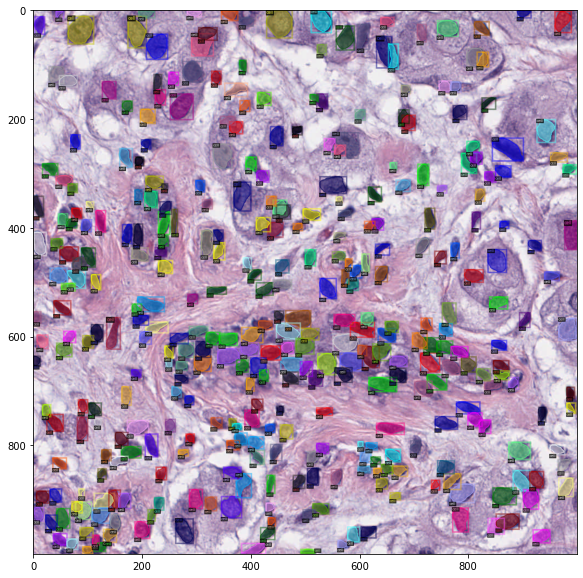

In [ ]:
cfg.MODEL.WEIGHTS = '/content/output/model_final.pth'
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.05
cfg.DATASETS.TEST = ("test_custom")
predictor = DefaultPredictor(cfg)


from detectron2.utils.visualizer import ColorMode
import random
from detectron2.data import DatasetCatalog, MetadataCatalog
from detectron2.utils.visualizer import ColorMode
from detectron2.utils.visualizer import Visualizer
import cv2
import matplotlib.pyplot as plt

dataset_dicts = DatasetCatalog.get("train_custom")
microcontroller_metadata = MetadataCatalog.get("train_custom")
ocontroller_metadata = MetadataCatalog.get("train_custom")

for d in random.sample(dataset_dicts, 1):
    img = cv2.imread(d["file_name"])
    print(d["file_name"])
    v = Visualizer(img[:, :, ::-1], metadata=microcontroller_metadata, scale=1,instance_mode=ColorMode.SEGMENTATION)
    v = v.draw_dataset_dict(d)
    plt.figure(figsize = (14, 10))
    plt.imshow(cv2.cvtColor(v.get_image()[:, :, ::-1], cv2.COLOR_BGR2RGB))
    plt.show()